In [496]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy
from netcal.metrics import ECE, ACE

from dataloader import get_dataloaders
from models.msdnet import MSDNet
from utils import parse_args
from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict


In [497]:
# MODEL_FOLDER = 'models_poe'  # alpha=0, sigmoid T schedule from 2 to 16
# LIKELIHOOD = 'OVR'
# EPOCH = 299

# MODEL_FOLDER = 'models'
# LIKELIHOOD = 'softmax'
# EPOCH = 299

# MODEL_FOLDER = 'models_poe_alpha_0'  # alpha=0, constant T kept at 1, wandb run id 15
# LIKELIHOOD = 'OVR'
# EPOCH = 299

# MODEL_FOLDER = 'models_hybrid_softmax_1'  # wandb run id 60
# LIKELIHOOD = 'softmax'
# EPOCH = 299

# MODEL_FOLDER = 'models_poe_alpha_001'  # wandb run id 57
# LIKELIHOOD = 'softmax'
# EPOCH = 299

MODEL_FOLDER = 'models_cascade_softmax'  # wandb run id 62
LIKELIHOOD = 'softmax'
EPOCH = 299

## 0 Load pretrained model and dataloaders

In [498]:
ARGS = parse_args()
ARGS.data_root = 'data'
ARGS.data = 'cifar100'
ARGS.save= f'/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/models/{MODEL_FOLDER}'
ARGS.arch = 'msdnet'
ARGS.batch_size = 64
ARGS.epochs = 300
ARGS.nBlocks = 7
ARGS.stepmode = 'even'
ARGS.base = 4
ARGS.nChannels = 16
ARGS.j = 16
ARGS.num_classes = 100
ARGS.step = 2
ARGS.use_valid = True
ARGS.splits = ['train', 'val', 'test']
ARGS.likelihood = LIKELIHOOD

In [499]:
# load pre-trained model
model = MSDNet(args=ARGS)
MODEL_PATH = f'models/{MODEL_FOLDER}/save_models/checkpoint_{EPOCH}.pth.tar'
state = torch.load(MODEL_PATH)
params = OrderedDict()
for params_name, params_val in state['state_dict'].items():
    params[params_name.replace('module.', '')] = params_val
    # state['state_dict'][params_name.replace('module.', '')] = state['state_dict'].pop(params_name)
model.load_state_dict(params)
model = model.cuda()
model.eval()

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

MSDNet(
  (blocks): ModuleList(
    (0): Sequential(
      (0): MSDNFirstLayer(
        (layers): ModuleList(
          (0): ConvBasic(
            (net): Sequential(
              (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): ConvBasic(
            (net): Sequential(
              (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (2): ConvBasic(
            (net): Sequential(
              (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [500]:
# data
_, _, test_loader = get_dataloaders(ARGS)

logits = []
targets = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        y = y.cuda(device=None)
        x = x.cuda()

        input_var = torch.autograd.Variable(x)
        target_var = torch.autograd.Variable(y)

        output = model(input_var)
        if not isinstance(output, list):
            output = [output]

        logits.append(torch.stack(output))
        targets.append(target_var)

logits = torch.cat(logits, dim=1).cpu()
targets = torch.cat(targets).cpu()

Files already downloaded and verified
Files already downloaded and verified
!!!!!! Save train_set_index !!!!!!


### unit-testing

In [501]:
L = len(logits)
a = torch.softmax(logits, dim=2)
a_cumsum = a.cumsum(dim=0)
a_cumsum_mean = a.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]

n = 7390
c = 77

tmp = 0
for i in range(7):
    tmp += a[i, n, c]
    assert np.isclose(a_cumsum[i, n, c], tmp)
    assert np.isclose(a_cumsum_mean[i, n, c], (tmp / (i + 1)))
    # print(tmp, tmp / (i + 1))

## 1 Softmax

### 1.1 anytime-prediction: performance

In [502]:
L = len(logits)

In [503]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [504]:
probs = torch.softmax(logits, dim=2)
probs_de = probs.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
preds_de = {i: torch.argmax(probs_de, dim=2)[i, :] for i in range(L)}
acc_de = [(targets == preds_de[i]).sum() / len(targets) for i in range(L)]

In [505]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

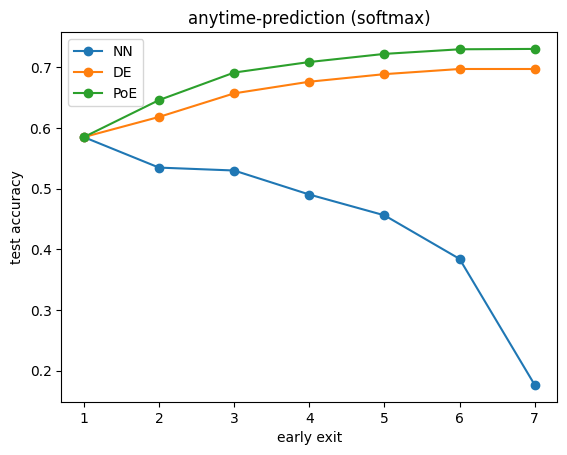

In [506]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc, label='NN', marker='o')
plt.plot(early_exits, acc_de, label='DE', marker='o')
plt.plot(early_exits, acc_poe, label='PoE', marker='o')
plt.legend()
plt.title('anytime-prediction (softmax)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

### 1.2 anytime-prediction: modal probability 

#### 1.2.1 plots

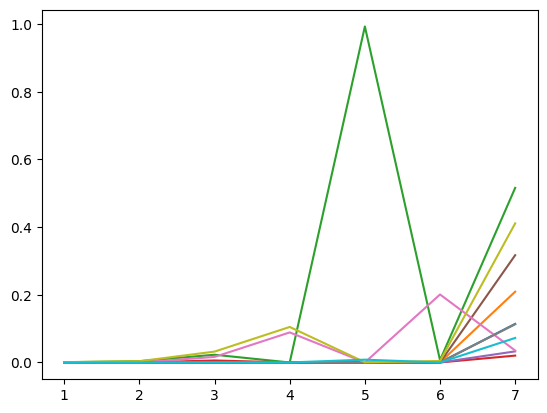

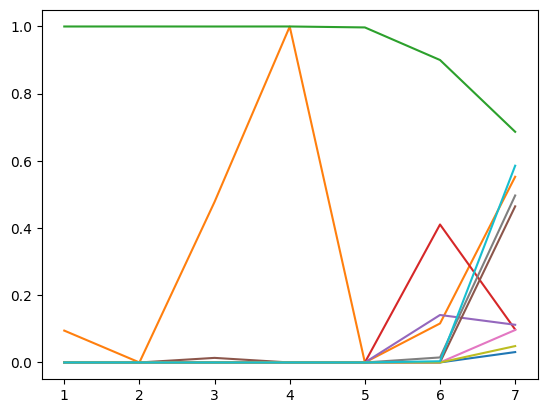

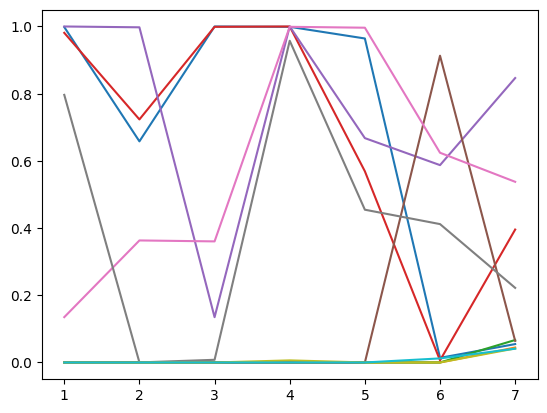

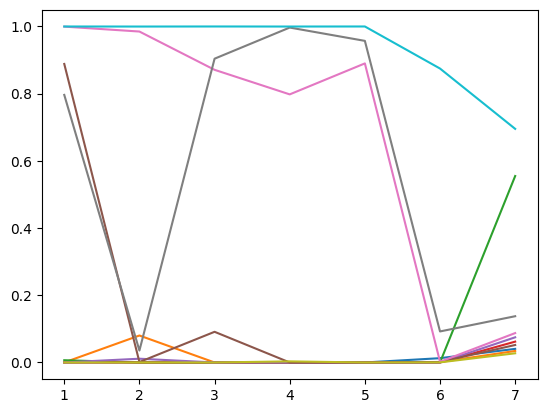

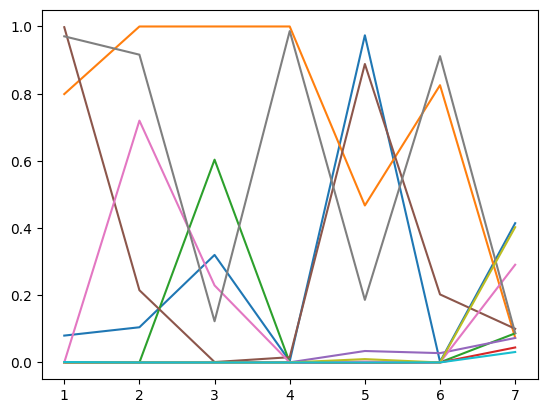

In [507]:
_preds = preds[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

#### 1.2.2 nr. of test examples with decreasing modal probabilities throughout sequential evaluation

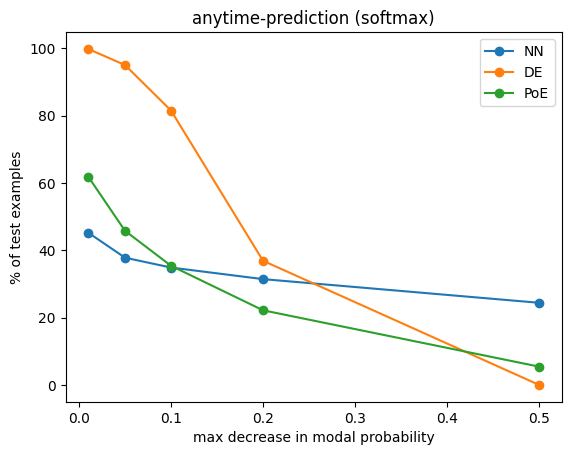

In [508]:
for _preds, _poe, label in [(preds, probs, 'NN'), (preds_de, probs_de, 'DE'), (preds_poe, probs_poe, 'PoE')]:
    modal_probs = modal_probs_decreasing(_preds, _poe, L)
    plt.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
plt.legend()
plt.title('anytime-prediction (softmax)')
plt.xlabel('max decrease in modal probability')
plt.ylabel('% of test examples')
plt.show()

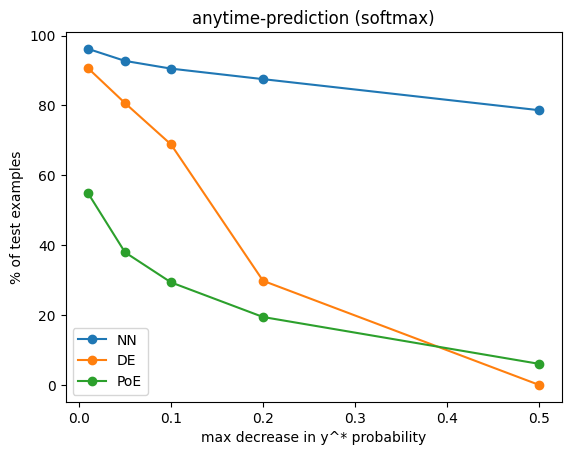

In [509]:
_targets = {l: targets for l in range(L)}
for _preds, _poe, label in [(_targets, probs, 'NN'), (_targets, probs_de, 'DE'), (_targets, probs_poe, 'PoE')]:
    modal_probs = modal_probs_decreasing(_preds, _poe, L)
    plt.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
plt.legend()
plt.title('anytime-prediction (softmax)')
plt.xlabel('max decrease in y^* probability')
plt.ylabel('% of test examples')
plt.show()

#### 1.2.3 MSP throughout sequential evaluation

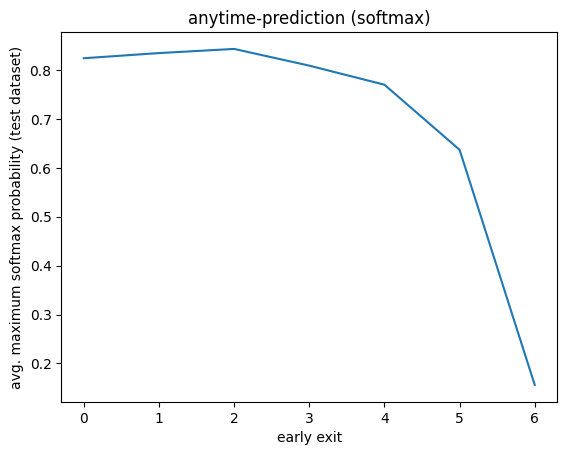

In [510]:
plt.plot(list(range(len(msp))), [msp[j].mean() for j in range(len(msp))])
plt.title('anytime-prediction (softmax)')
plt.xlabel('early exit')
plt.ylabel('avg. maximum softmax probability (test dataset)')
plt.show()

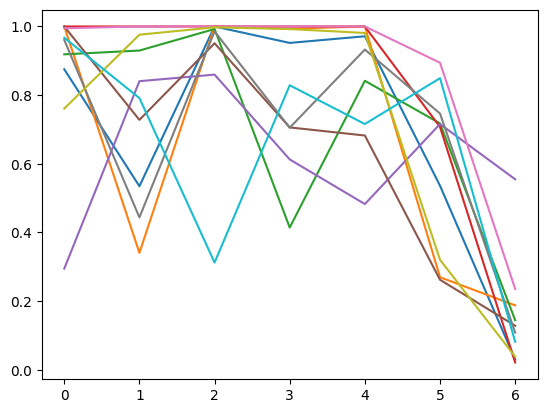

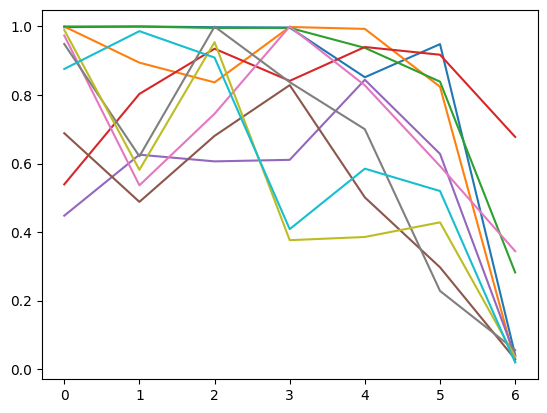

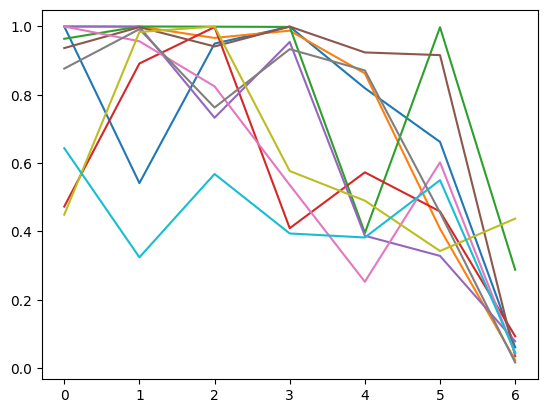

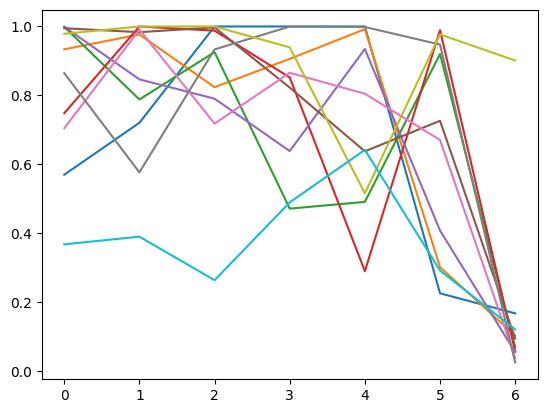

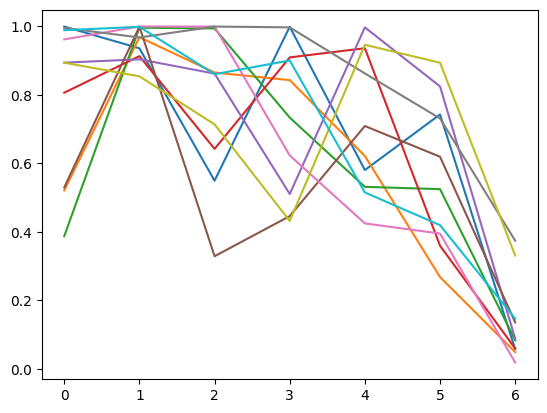

In [511]:
for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        msp_i = [msp[j][i] for j in range(len(msp))]
        plt.plot(list(range(len(msp_i))), msp_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

#### 1.2.4 rankings plots

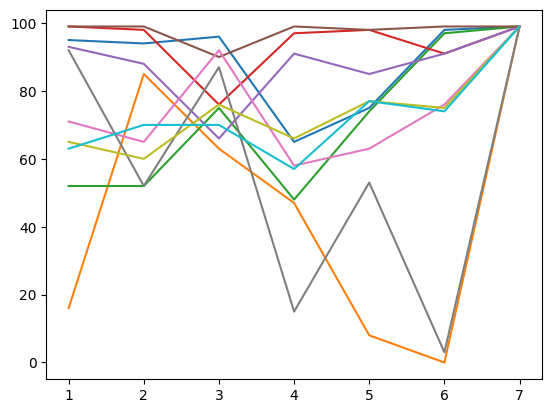

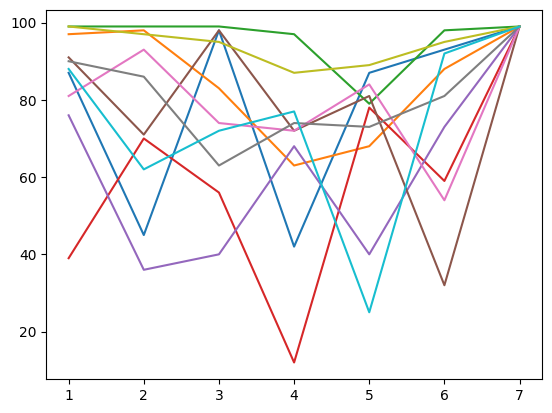

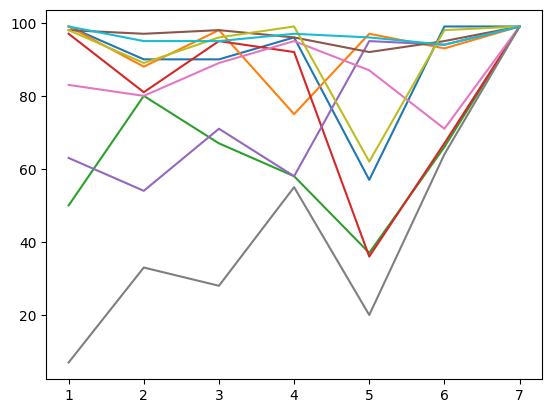

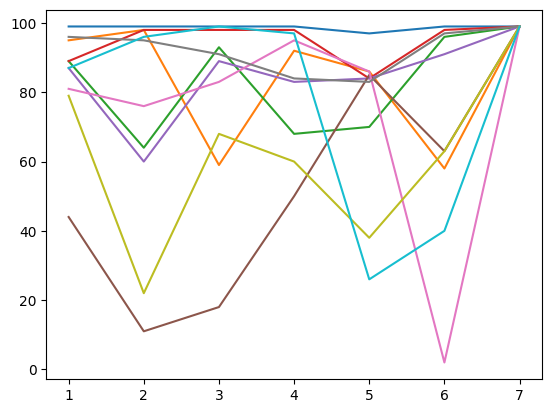

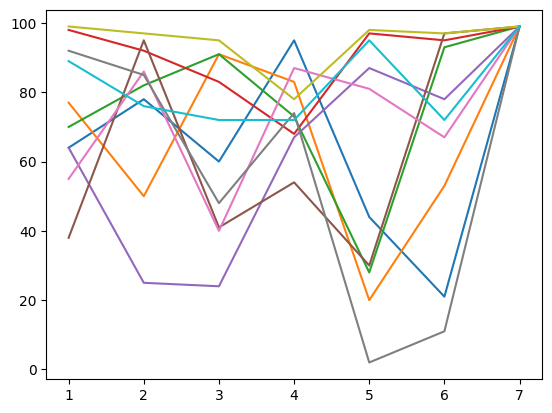

In [512]:
_preds = preds[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        rankings_i = [np.where(_probs[l, i, :].numpy().argsort() == int(_preds[i]))[0][0] for l in range(L)]
        plt.plot(list(range(1, len(rankings_i) + 1)), rankings_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

## 2 OVR

### 2.1 anytime-prediction: performance

In [513]:
probs_ovr = ovr_likelihood(logits)
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets == preds_ovr[i]).sum() / len(targets) for i in range(L)]
ids_ood_ovr = get_ood_ovr(probs_ovr)
nr_ood_ovr = {l: len(l_dict) for l, l_dict in ids_ood_ovr.items()}

_ids = {l: [i for i in range(10000) if i not in l_ids] for l, l_ids in ids_ood_ovr.items()}
acc_ovr_excluding_ood = [(targets[_ids[i]] == preds_ovr[i][_ids[i]]).sum() / len(targets[_ids[i]]) for i in range(L)]

In [514]:
probs_ovr = ovr_likelihood(logits)
probs_poe_ovr = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets == preds_poe_ovr[i]).sum() / len(targets) for i in range(L)]
ids_ood_poe_ovr = get_ood_ovr(probs_poe_ovr)
nr_ood_poe_ovr = {l: len(l_dict) for l, l_dict in ids_ood_poe_ovr.items()}

_ids = {l: [i for i in range(10000) if i not in l_ids] for l, l_ids in ids_ood_poe_ovr.items()}
acc_poe_ovr_excluding_ood = [(targets[_ids[i]] == preds_poe_ovr[i][_ids[i]]).sum() / len(targets[_ids[i]]) for i in range(L)]

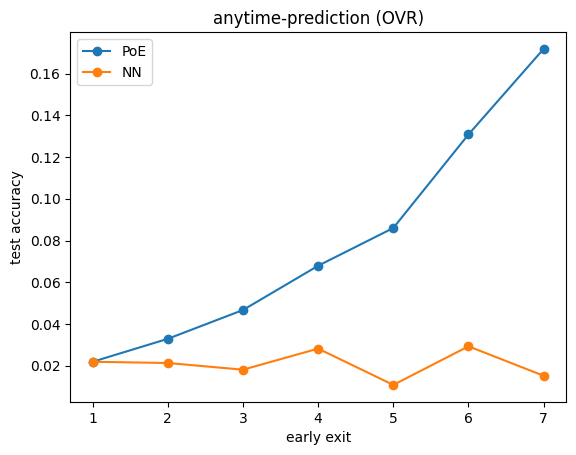

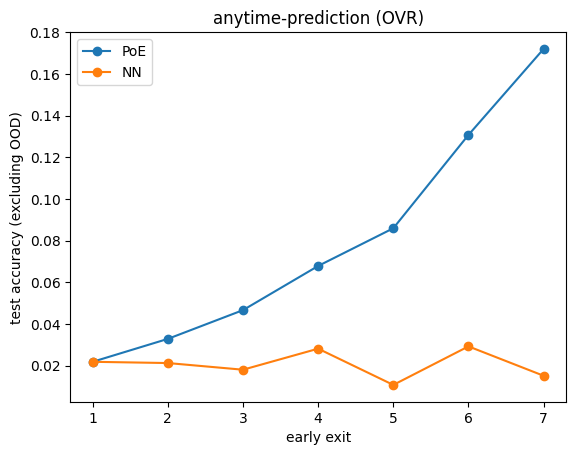

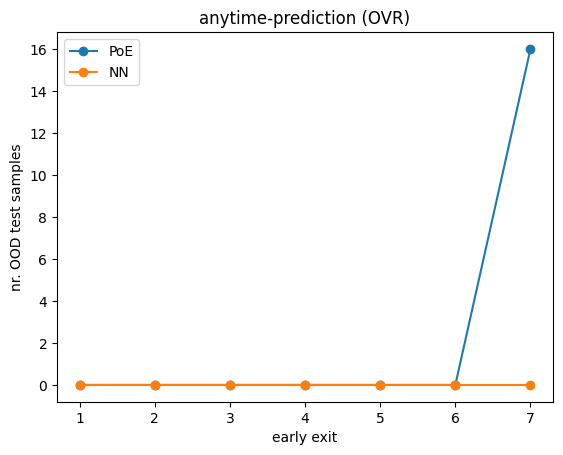

In [515]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc_poe_ovr, marker='o', label='PoE')
plt.plot(early_exits, acc_ovr, marker='o', label='NN')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, acc_poe_ovr_excluding_ood, marker='o', label='PoE')
plt.plot(early_exits, acc_ovr_excluding_ood, marker='o', label='NN')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('test accuracy (excluding OOD)')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, nr_ood_poe_ovr.values(), marker='o', label='PoE')
plt.plot(early_exits, nr_ood_ovr.values(), marker='o', label='NN')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('nr. OOD test samples')
plt.xlabel('early exit')
plt.show()

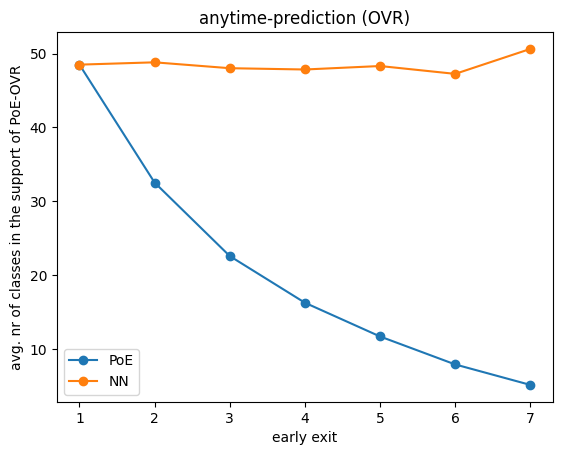

In [516]:
plt.plot(list(range(1, L + 1)), [np.mean((probs_poe_ovr[l] > 0).sum(axis=1).numpy()) for l in range(L)], marker='o', label='PoE')
plt.plot(list(range(1, L + 1)), [np.mean((probs_ovr[l] > 0).sum(axis=1).numpy()) for l in range(L)], marker='o', label='NN')
plt.title('anytime-prediction (OVR)')
plt.ylabel('avg. nr of classes in the support of PoE-OVR')
plt.xlabel('early exit')
plt.legend()
plt.show()

In [517]:
modal_probs_ovr = modal_probs_decreasing(preds_poe_ovr, probs_poe_ovr, L)
for thres, val in modal_probs_ovr.items():
    print(thres, val)

0.01 0.05
0.05 0.02
0.1 0.02
0.2 0.0
0.5 0.0


### 2.2 fallback on (product of sigmoid of) logits in case of zero prob

In [518]:
preds_ovr_fallback_ood = f_preds_ovr_fallback_ood(logits=logits, probs=probs_ovr)
probs_ovr_fallback_ood = f_probs_ovr_fallback_ood(logits=logits, probs=probs_ovr)
acc_ovr_fallback_ood = [(targets == preds_ovr_fallback_ood[i]).sum() / len(targets) for i in range(L)]

preds_poe_ovr_fallback_ood = f_preds_ovr_fallback_ood(logits=logits, probs=probs_poe_ovr, prod=True)
probs_poe_ovr_fallback_ood = f_probs_ovr_fallback_ood(logits=logits, probs=probs_poe_ovr, prod=True)
acc_poe_ovr_fallback_ood = [(targets == preds_poe_ovr_fallback_ood[i]).sum() / len(targets) for i in range(L)]

In [519]:
# unit tests for f_probs_ovr_fallback_ood
_preds_ovr_fallback_ood = {i: torch.argmax(probs_ovr_fallback_ood, dim=2)[i, :] for i in range(L)}
_preds_poe_ovr_fallback_ood = {i: torch.argmax(probs_poe_ovr_fallback_ood, dim=2)[i, :] for i in range(L)}
for j in range(L):
    torch.equal(preds_ovr_fallback_ood[j], _preds_ovr_fallback_ood[j])
    torch.equal(preds_poe_ovr_fallback_ood[j], _preds_poe_ovr_fallback_ood[j])

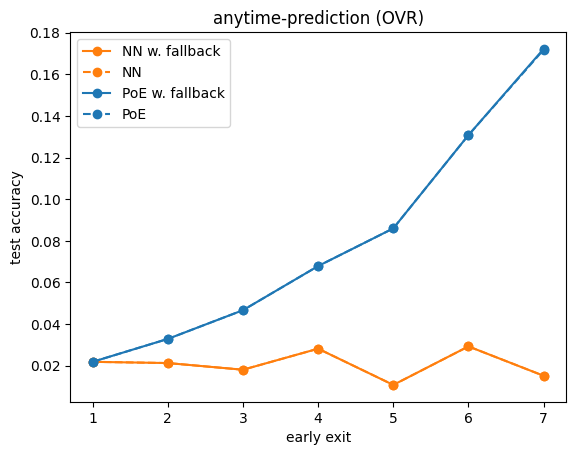

In [520]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc_ovr_fallback_ood, marker='o', label='NN w. fallback', color='#ff7f0e')
plt.plot(early_exits, acc_ovr, marker='o', label='NN', color='#ff7f0e', linestyle='--')
plt.plot(early_exits, acc_poe_ovr_fallback_ood, marker='o', label='PoE w. fallback', c='#1f77b4')
plt.plot(early_exits, acc_poe_ovr, marker='o', label='PoE', c='#1f77b4', linestyle='--')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

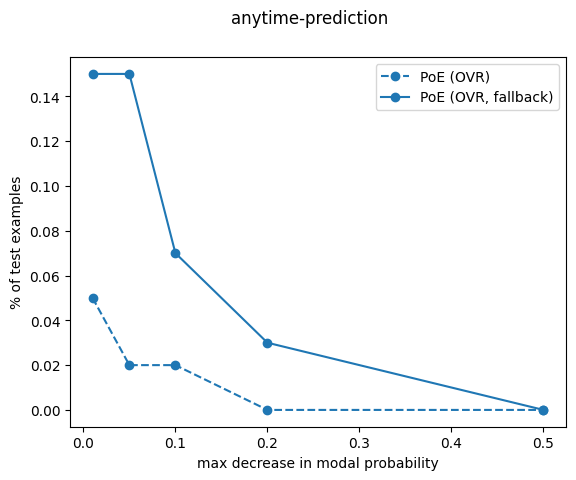

In [521]:
for _preds, _poe, label, linestyle in [(preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)', '--'),
                            (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fallback)', '-')]:
    modal_probs = modal_probs_decreasing(_preds, _poe, L)
    plt.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label, c='#1f77b4', linestyle=linestyle)
plt.legend()
# ax[1].set_title('anytime-prediction')
plt.xlabel('max decrease in modal probability')
plt.ylabel('% of test examples')
plt.suptitle('anytime-prediction')
plt.show()

In [522]:
modal_probs = modal_probs_decreasing(preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, L, verbose=True)

327 [0.0212766  0.03703704 0.04545455 0.06666667 0.14285715 0.33333334
 0.17274073]
327 [0.0212766  0.03703704 0.04545455 0.06666667 0.14285715 0.33333334
 0.17274073]
327 [0.0212766  0.03703704 0.04545455 0.06666667 0.14285715 0.33333334
 0.17274073]
1118 [0.01960784 0.03125    0.05555556 0.11111111 0.16666667 0.5
 0.17054193]
1118 [0.01960784 0.03125    0.05555556 0.11111111 0.16666667 0.5
 0.17054193]
1118 [0.01960784 0.03125    0.05555556 0.11111111 0.16666667 0.5
 0.17054193]
1118 [0.01960784 0.03125    0.05555556 0.11111111 0.16666667 0.5
 0.17054193]
2005 [0.01923077 0.03225806 0.0625     0.1        0.2        0.
 0.17030255]
2005 [0.01923077 0.03225806 0.0625     0.1        0.2        0.
 0.17030255]
2005 [0.01923077 0.03225806 0.0625     0.1        0.2        0.
 0.17030255]
2853 [0.02040816 0.03125    0.04761905 0.07142857 0.         0.
 0.22871533]
2853 [0.02040816 0.03125    0.04761905 0.07142857 0.         0.
 0.22871533]
2964 [0.01785714 0.02777778 0.05       0.07142857 0

### 2.3 break-ties (in case of distribution being not sharp enough/having too large support)

In [523]:
probs_poe_ovr_break_ties = f_probs_ovr_poe_break_ties(logits, probs_poe_ovr)
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

ids_ood_poe_ovr_break_ties = get_ood_ovr(probs_poe_ovr_break_ties)
nr_ood_poe_ovr_break_ties = {l: len(l_dict) for l, l_dict in ids_ood_poe_ovr_break_ties.items()}

_ids_bt = {l: [i for i in range(10000) if i not in l_ids] for l, l_ids in ids_ood_poe_ovr_break_ties.items()}
acc_poe_ovr_excluding_ood_break_ties = [(targets[_ids_bt[i]] == preds_poe_ovr_break_ties[i][_ids_bt[i]]).sum() / len(targets[_ids_bt[i]]) for i in range(L)]

In [524]:
msp_poe_ovr_break_ties = {i: torch.max(probs_poe_ovr_break_ties, dim=2).values[i, :] for i in range(L)}

In [525]:
acc_poe_ovr_break_ties

[tensor(0.3897),
 tensor(0.5127),
 tensor(0.5927),
 tensor(0.6267),
 tensor(0.6409),
 tensor(0.6148),
 tensor(0.4897)]

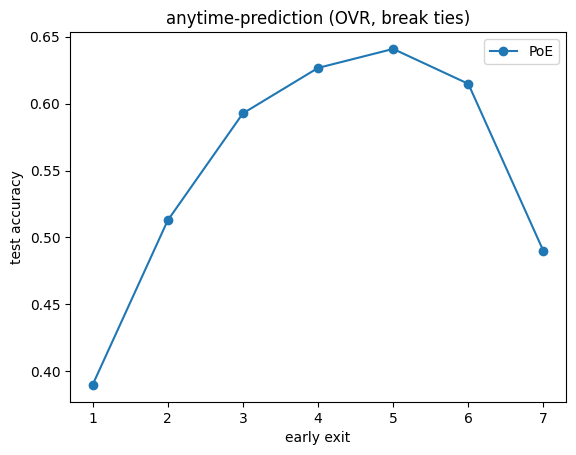

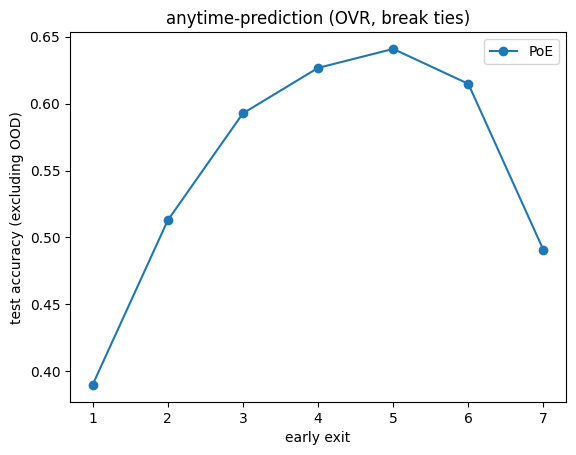

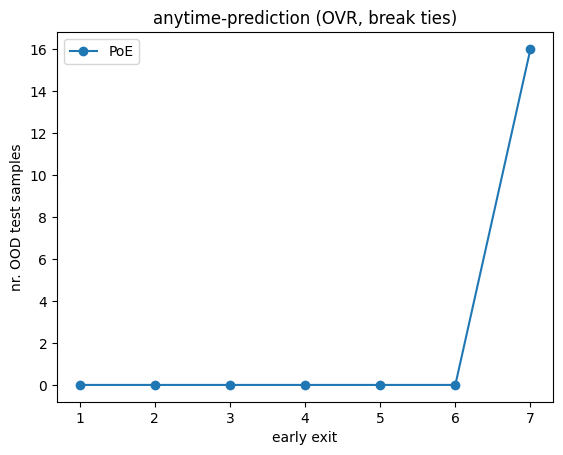

In [526]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc_poe_ovr_break_ties, marker='o', label='PoE')
plt.legend()
plt.title('anytime-prediction (OVR, break ties)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, acc_poe_ovr_excluding_ood_break_ties, marker='o', label='PoE')
plt.legend()
plt.title('anytime-prediction (OVR, break ties)')
plt.ylabel('test accuracy (excluding OOD)')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, nr_ood_poe_ovr_break_ties.values(), marker='o', label='PoE')
plt.legend()
plt.title('anytime-prediction (OVR, break ties)')
plt.ylabel('nr. OOD test samples')
plt.xlabel('early exit')
plt.show()

In [527]:
modal_probs_ovr_break_ties = modal_probs_decreasing(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, L)
for thres, val in modal_probs_ovr_break_ties.items():
    print(thres, val)

0.01 0.45999999999999996
0.05 0.04
0.1 0.01
0.2 0.0
0.5 0.0


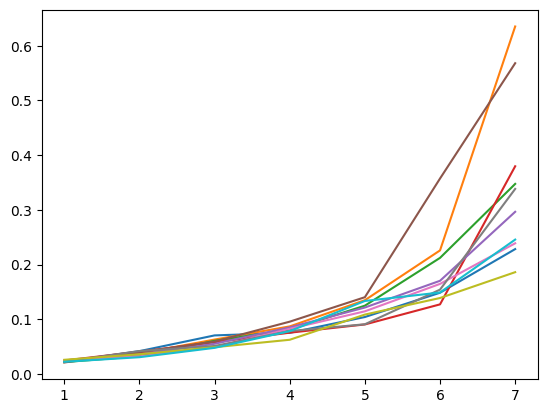

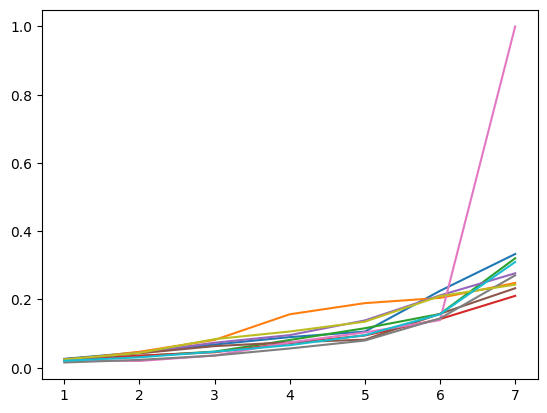

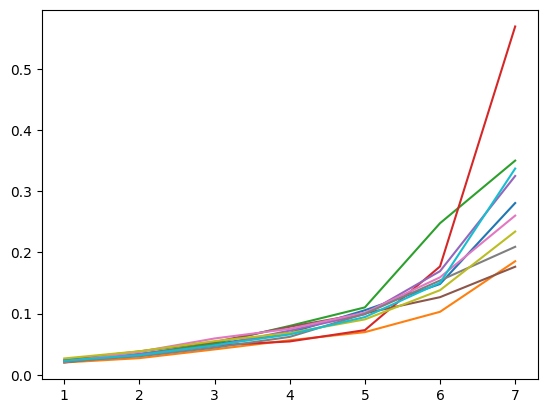

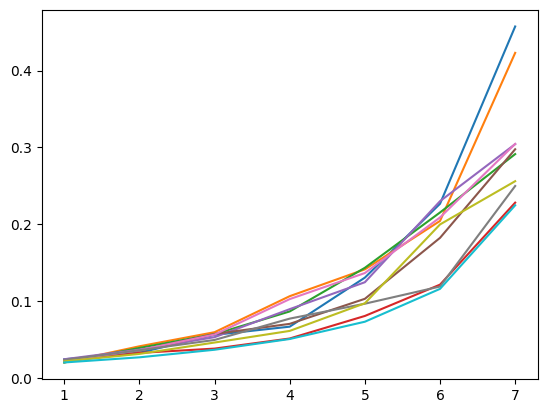

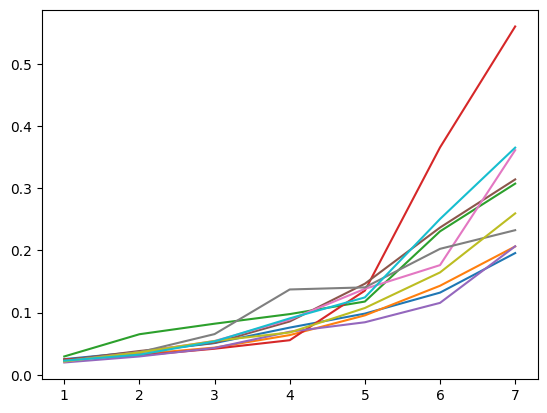

In [528]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

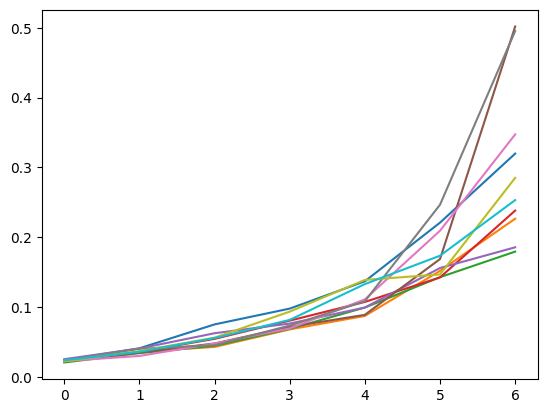

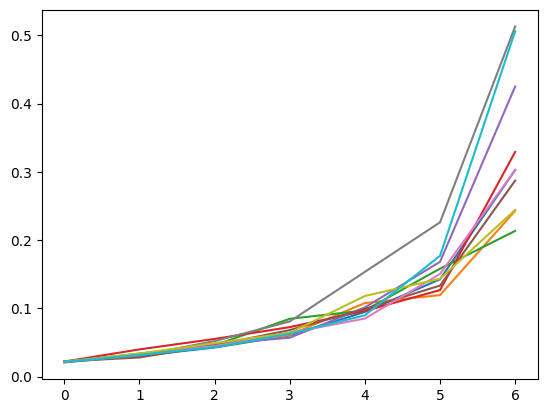

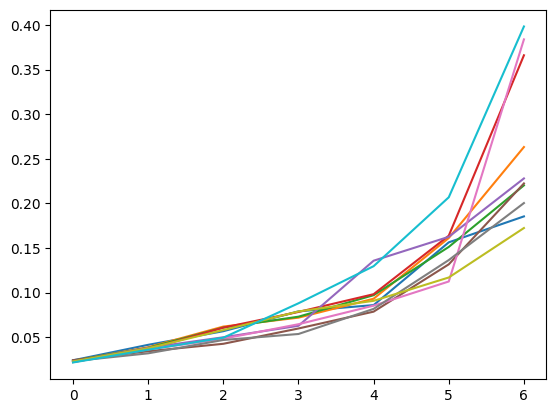

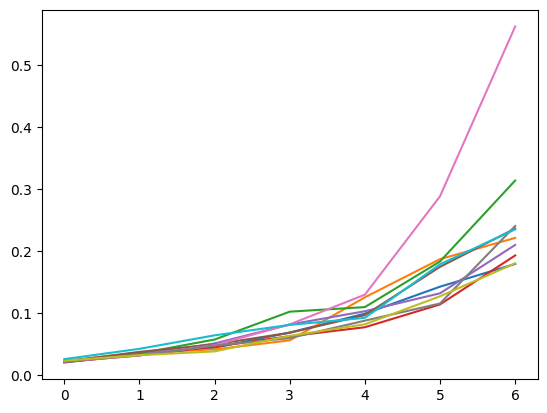

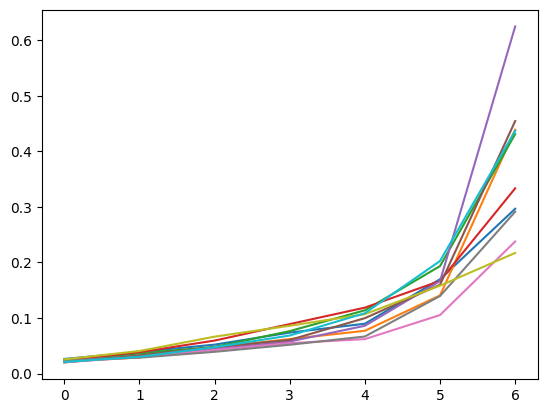

In [529]:
for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        msp_i = [msp_poe_ovr_break_ties[j][i] for j in range(len(msp))]
        plt.plot(list(range(len(msp_i))), msp_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

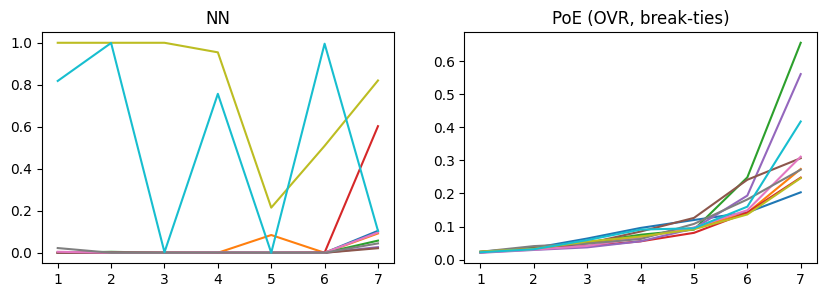

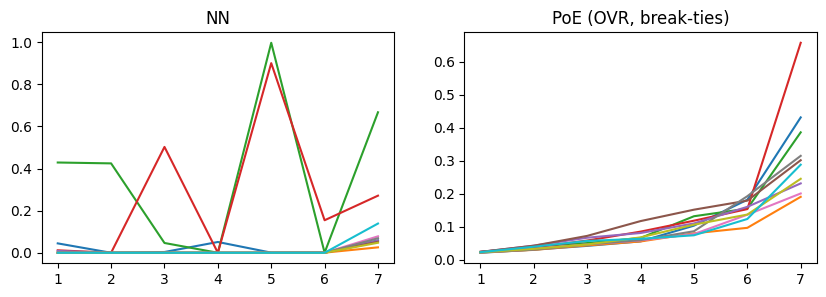

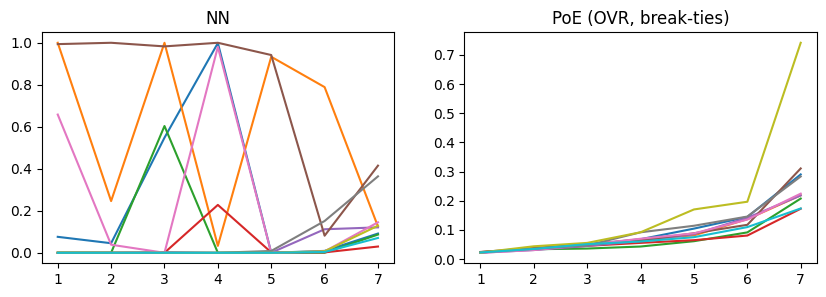

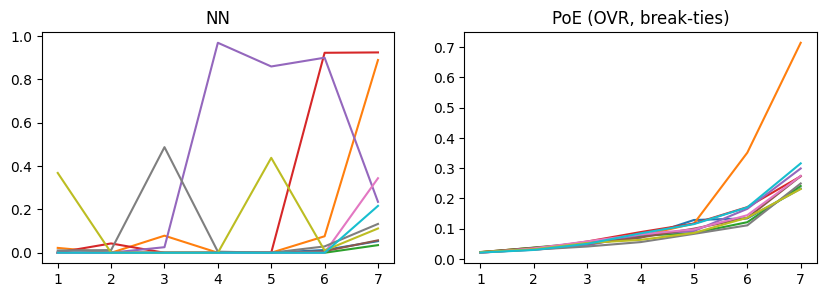

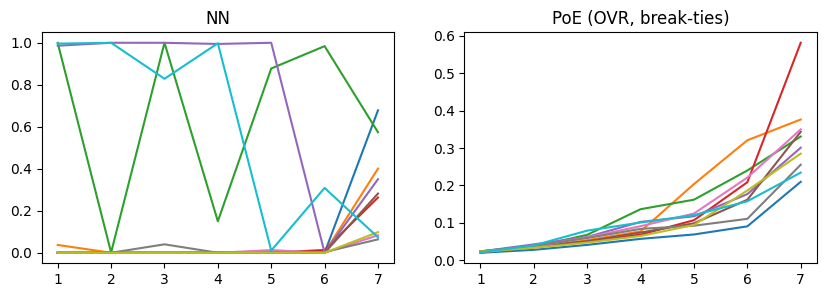

In [530]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('NN')
    ax[1].set_title('PoE (OVR, break-ties)')
    plt.show()

### 2.4 break-ties and tempering

TODO: understand why temperature scaling with T > 1 leads to drop in accuracy for OVR, break-ties

In [531]:
# probs_poe_ovr_break_ties_tempered = f_probs_ovr_poe_break_ties(logits, probs_poe_ovr, T=0.01)
# preds_poe_ovr_break_ties_tempered = {i: torch.argmax(probs_poe_ovr_break_ties_tempered, dim=2)[i, :] for i in range(L)}
# acc_poe_ovr_break_ties_tempered = [(targets == preds_poe_ovr_break_ties_tempered[i]).sum() / len(targets) for i in range(L)]

In [532]:
# probs_poe_ovr_break_ties_tempered[6, 0, :]

In [533]:
# acc_poe_ovr_break_ties_tempered

In [534]:
# modal_probs_ovr_break_ties_tempered = modal_probs_decreasing(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, L)
# for thres, val in modal_probs_ovr_break_ties_tempered.items():
#     print(thres, val)

### 2.5 break-ties and softmax-tempering

apply softmax with large T to OVR, break-ties probabilities in order to scale them up while preserving the ranking

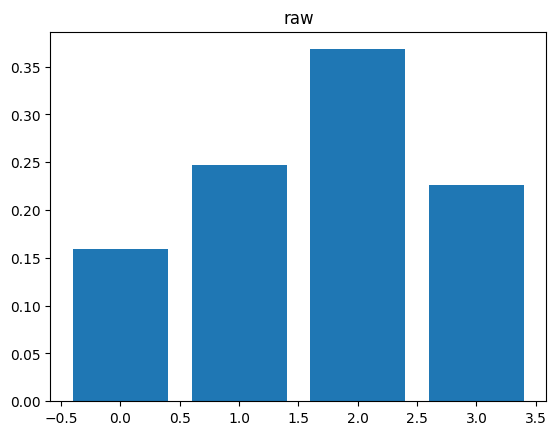

tensor([0, 3, 1, 2])


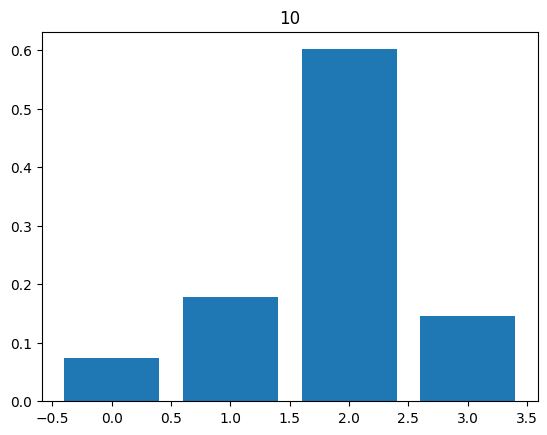

tensor([0, 3, 1, 2])


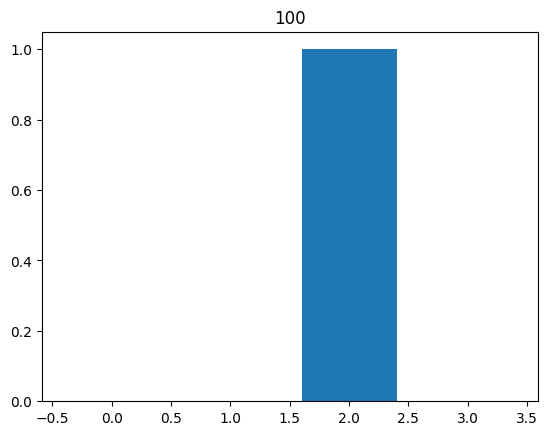

tensor([0, 3, 1, 2])


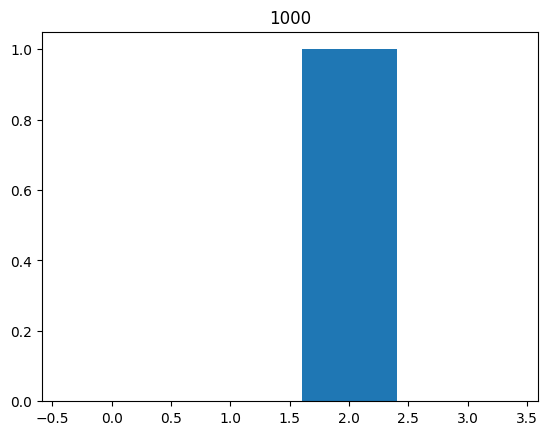

tensor([0, 1, 3, 2])


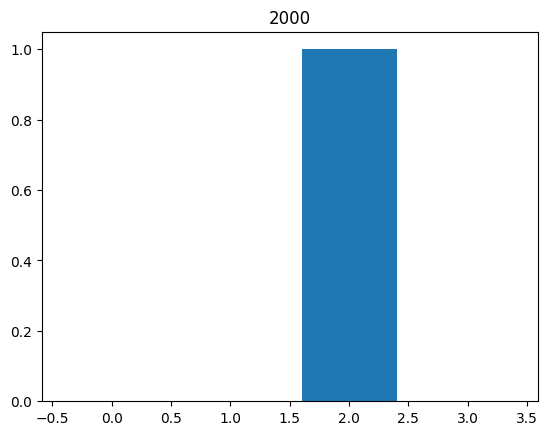

tensor([0, 1, 3, 2])


In [535]:
example_probs = probs_poe_ovr_break_ties[6, 0, :]
support_mask = (example_probs != 0.)
nr_non_zero = support_mask.sum().numpy()

support = np.arange(0, nr_non_zero, 1)

plt.bar(support, example_probs[support_mask])
plt.title('raw')
plt.show()
print(torch.argsort(example_probs[support_mask]))
for T in [10, 100, 1000, 2000]:
    _tempered_probs = torch.softmax(T * example_probs[support_mask], dim=0)
    plt.bar(support, _tempered_probs)
    plt.title(f'{T}')
    plt.show()
    print(torch.argsort(_tempered_probs))

In [536]:
T = 10000.
probs_poe_ovr_break_ties_tempered_softmax = probs_poe_ovr_break_ties.clone()
for l in range(probs_poe_ovr_break_ties_tempered_softmax.shape[0]):
    for n in range(probs_poe_ovr_break_ties_tempered_softmax.shape[1]):
        _probs_l_n_mask = probs_poe_ovr_break_ties_tempered_softmax[l, n, :] != 0.
        _tempered_probs = torch.softmax(T * probs_poe_ovr_break_ties_tempered_softmax[l, n, :][_probs_l_n_mask], dim=0)
        probs_poe_ovr_break_ties_tempered_softmax[l, n, :][_probs_l_n_mask] = _tempered_probs


preds_poe_ovr_break_ties_tempered_softmax = {i: torch.argmax(probs_poe_ovr_break_ties_tempered_softmax, dim=2)[i, :] for i in range(L)}

In [537]:
for l in range(L):
    print(l, (preds_poe_ovr_break_ties_tempered_softmax[l] == preds_poe_ovr_break_ties[l]).sum())

0 tensor(9991)
1 tensor(9995)
2 tensor(9993)
3 tensor(9999)
4 tensor(9998)
5 tensor(10000)
6 tensor(10000)


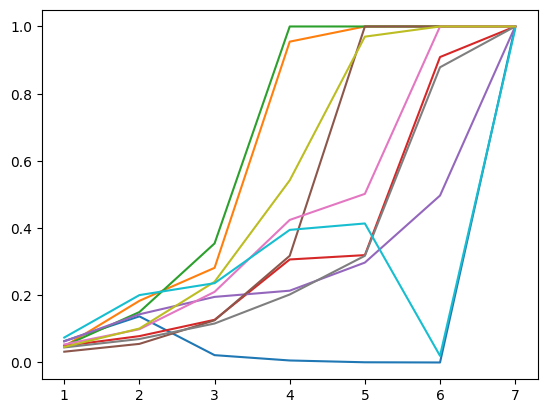

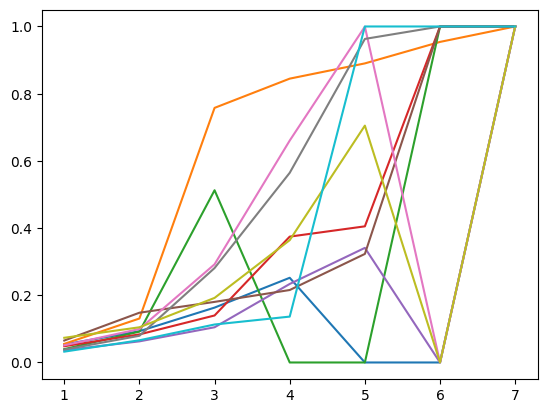

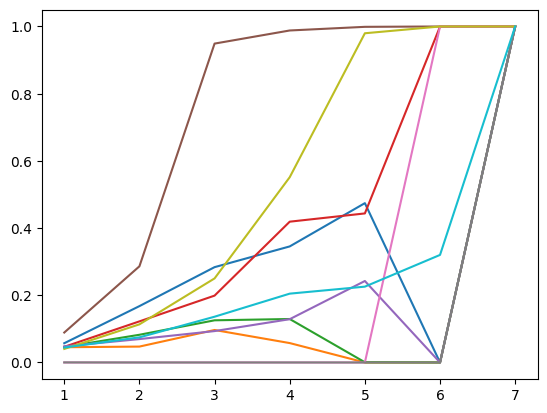

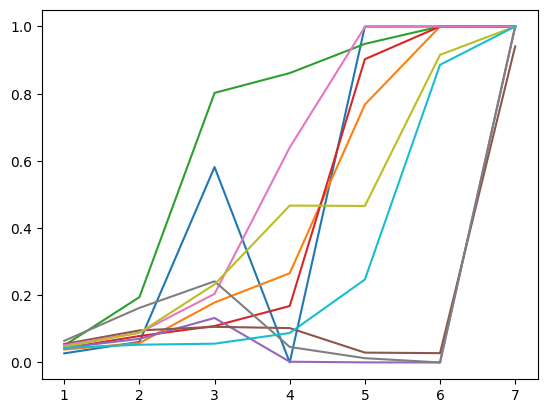

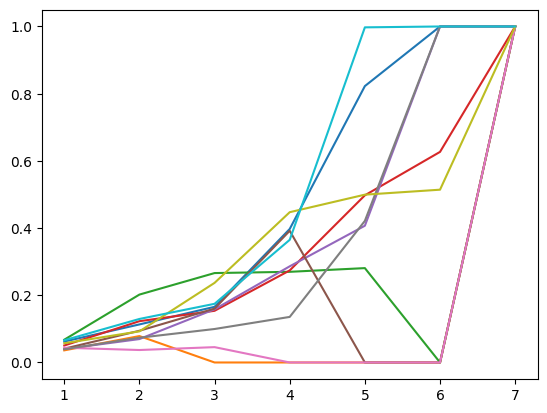

In [538]:
_preds = preds_poe_ovr_break_ties_tempered_softmax[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties_tempered_softmax

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

#### while softmax-tempering helps with rescaling the probabilities (see above), the calibration in terms of ECE remains poor (see below)

1
 ECE OVR: 0.001
 ECE OVR, break-ties: 0.367
 ECE OVR, break-ties, softmax-tempered: 0.336
2
 ECE OVR: 0.002
 ECE OVR, break-ties: 0.478
 ECE OVR, break-ties, softmax-tempered: 0.389
3
 ECE OVR: 0.001
 ECE OVR, break-ties: 0.540
 ECE OVR, break-ties, softmax-tempered: 0.363
4
 ECE OVR: 0.005
 ECE OVR, break-ties: 0.550
 ECE OVR, break-ties, softmax-tempered: 0.300
5
 ECE OVR: 0.007
 ECE OVR, break-ties: 0.527
 ECE OVR, break-ties, softmax-tempered: 0.265
6
 ECE OVR: 0.012
 ECE OVR, break-ties: 0.431
 ECE OVR, break-ties, softmax-tempered: 0.323
7
 ECE OVR: 0.063
 ECE OVR, break-ties: 0.186
 ECE OVR, break-ties, softmax-tempered: 0.506


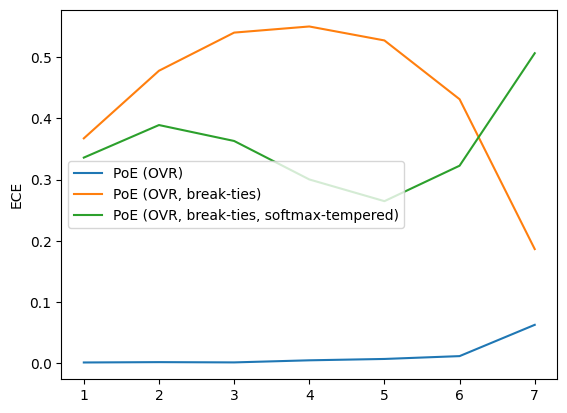

In [539]:
ece_poe_ovr, ece_poe_ovr_break_ties, ece_poe_ovr_break_ties_softmax_tempered = [], [], []
for l in range(L):
    _ece_poe_ovr = ECE(bins=15).measure(probs_poe_ovr[l, :, :].numpy(), targets.numpy())
    _ece_poe_ovr_break_ties = ECE(bins=15).measure(probs_poe_ovr_break_ties[l, :, :].numpy(), targets.numpy())
    _ece_poe_ovr_break_ties_softmax_tempered = ECE(bins=15).measure(probs_poe_ovr_break_ties_tempered_softmax[l, :, :].numpy(), targets.numpy())
    print(f'{l + 1}')
    print(f' ECE OVR: {_ece_poe_ovr:.3f}')
    print(f' ECE OVR, break-ties: {_ece_poe_ovr_break_ties:.3f}')
    print(f' ECE OVR, break-ties, softmax-tempered: {_ece_poe_ovr_break_ties_softmax_tempered:.3f}')
    ece_poe_ovr.append(_ece_poe_ovr)
    ece_poe_ovr_break_ties.append(_ece_poe_ovr_break_ties)
    ece_poe_ovr_break_ties_softmax_tempered.append(_ece_poe_ovr_break_ties_softmax_tempered)



plt.plot(list(range(1, L + 1)), ece_poe_ovr, label='PoE (OVR)')
plt.plot(list(range(1, L + 1)), ece_poe_ovr_break_ties, label='PoE (OVR, break-ties)')
plt.plot(list(range(1, L + 1)), ece_poe_ovr_break_ties_softmax_tempered, label='PoE (OVR, break-ties, softmax-tempered)')
plt.ylabel('ECE')
plt.legend()
plt.show()

### 2.6 Rankings plots

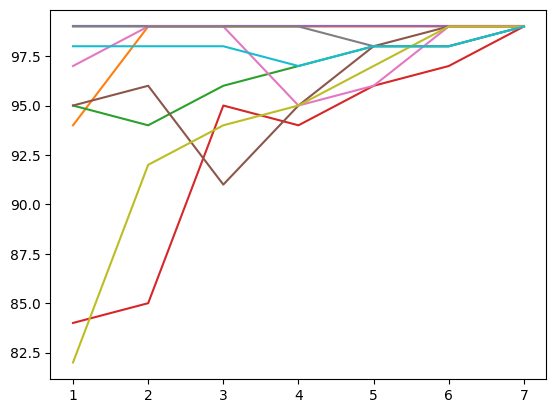

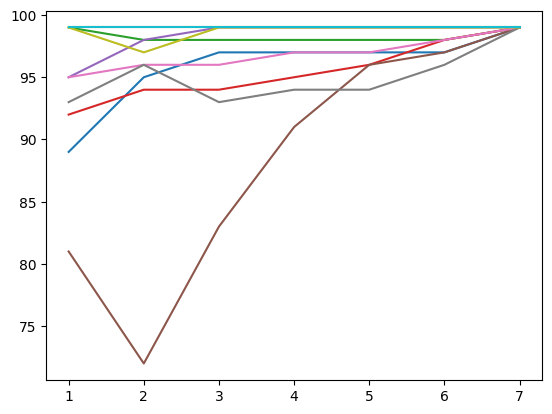

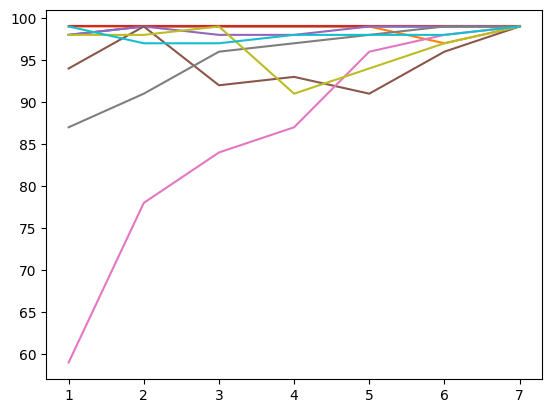

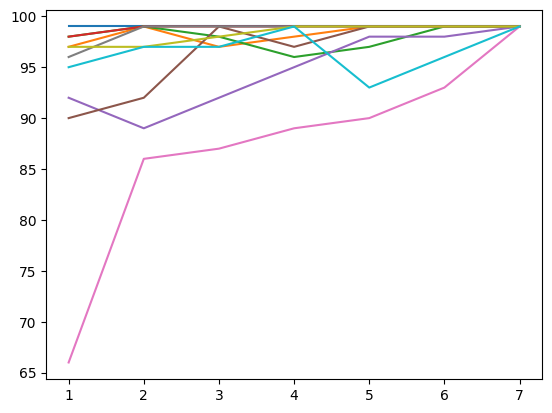

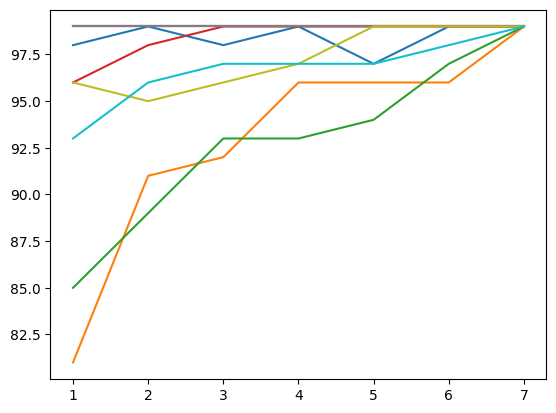

In [540]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        rankings_i = [np.where(_probs[l, i, :].numpy().argsort() == int(_preds[i]))[0][0] for l in range(L)]
        plt.plot(list(range(1, len(rankings_i) + 1)), rankings_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

PoE-OVR-break_ties
[(0, 4553), (1, 1990), (2, 1050), (3, 572), (4, 431)]
PoE-softmax
[(0, 8040), (1, 1277), (2, 348), (3, 139), (4, 69)]
DE-softmax
[(0, 7503), (1, 1759), (2, 283), (3, 113), (4, 66)]


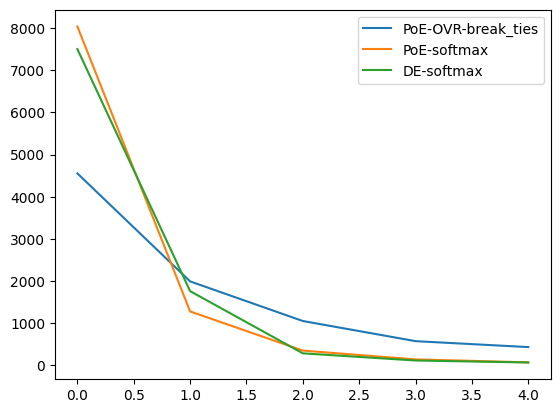

In [541]:
# # _preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
# _probs = probs_poe_ovr_break_ties

# # _preds = preds[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
# _probs = probs

# # _preds = preds_poe[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
# _probs = probs_poe

# # _preds = preds_de[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
# _probs = probs_de


plot_targets = False
for _preds, _probs, name in [
                             # (preds[L - 1], probs, 'NN'),
                             (preds_poe_ovr_break_ties[L - 1], probs_poe_ovr_break_ties, 'PoE-OVR-break_ties'),
                            # (preds_poe_ovr[L - 1], probs_poe_ovr, 'PoE-OVR'),
                             
                             (preds_poe[L - 1], probs_poe, 'PoE-softmax'),
                             (preds_de[L - 1], probs_de, 'DE-softmax')
                             ]:
    if plot_targets:
        _preds = targets
    diffs = []
    for i in range(10000):
        rankings_i = [np.where(_probs[l, i, :].numpy().argsort() == int(_preds[i]))[0][0] for l in range(L)]
        diffs.append(np.diff(rankings_i).min())

    diffs = [-d for d in diffs]
    diffs = Counter(diffs)
    print(name)
    print(diffs.most_common()[:5])
    plt.plot(*zip(*diffs.most_common()[:5]), label=f'{name}')


# plt.plot([0, 1, 2, 3, 4], [10000, 0, 0, 0, 0], label='f*', linestyle='--', color='black')
plt.legend()
plt.show()

## 3 Summary

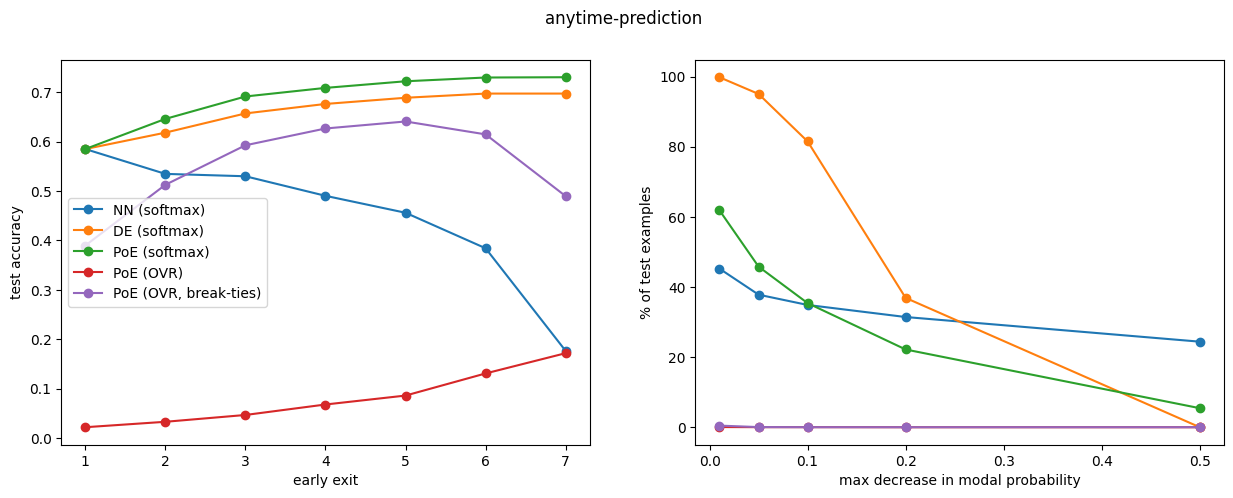

In [555]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='NN (softmax)', marker='o',)
ax[0].plot(early_exits, acc_de, label='DE (softmax)', marker='o')
ax[0].plot(early_exits, acc_poe, label='PoE (softmax)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr, label='PoE (OVR)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (OVR, break-ties)', marker='o')
# ax[0].plot(early_exits, acc_poe_ovr_fallback_ood, label='PoE (OVR, fall-back)', marker='o')
ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, 'NN (softmax)'), 
                            (preds_de, probs_de, 'DE (softmax)'), 
                            (preds_poe, probs_poe, 'PoE (softmax)'),
                            (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                            # (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
# ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle('anytime-prediction')
plt.show()

### 3.1 poor calibration

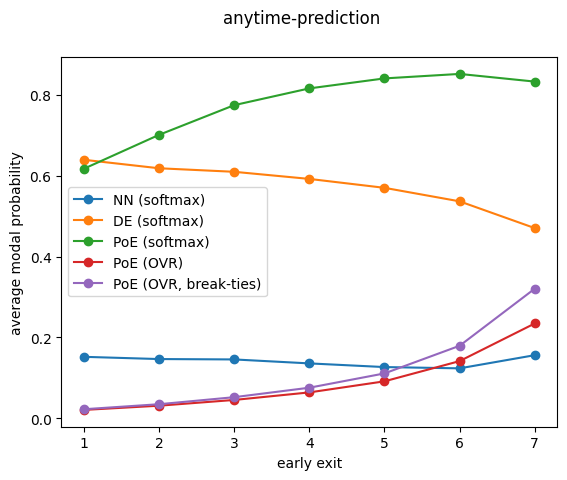

In [556]:
early_exits = [i + 1 for i in range(len(acc))]
for _preds, _probs, label in [
                            (preds, probs, 'NN (softmax)'), 
                            (preds_de, probs_de, 'DE (softmax)'), 
                            (preds_poe, probs_poe, 'PoE (softmax)'),
                            (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                            # (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                            ]:
    modal_probs = modal_probs_average(_preds, _probs, L)
    plt.plot(early_exits, modal_probs.numpy(), marker='o', label=label)
plt.legend()
plt.xlabel('early exit')
plt.ylabel('average modal probability')


plt.suptitle('anytime-prediction')
plt.show()

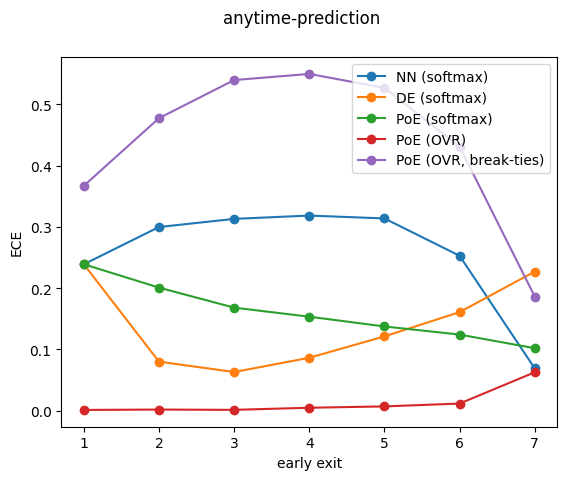

: 

In [557]:
early_exits = [i + 1 for i in range(len(acc))]
for _probs, label in [
                      (probs, 'NN (softmax)'),  
                      (probs_de, 'DE (softmax)'), 
                      (probs_poe, 'PoE (softmax)'),
                      (probs_poe_ovr, 'PoE (OVR)'),
                      (probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                      # (probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                      ]:
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    plt.plot(early_exits, ece, marker='o', label=label)
plt.legend()
plt.xlabel('early exit')
plt.ylabel('ECE')

plt.suptitle('anytime-prediction')
plt.show()

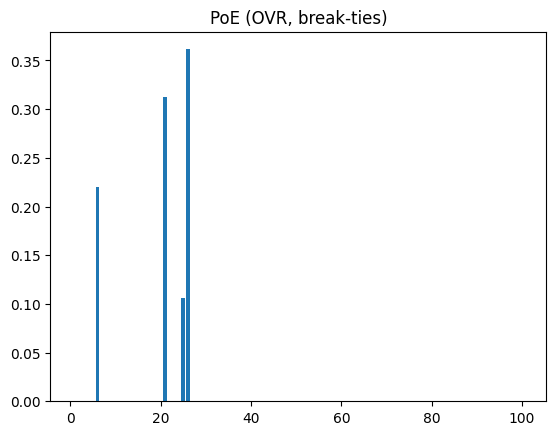

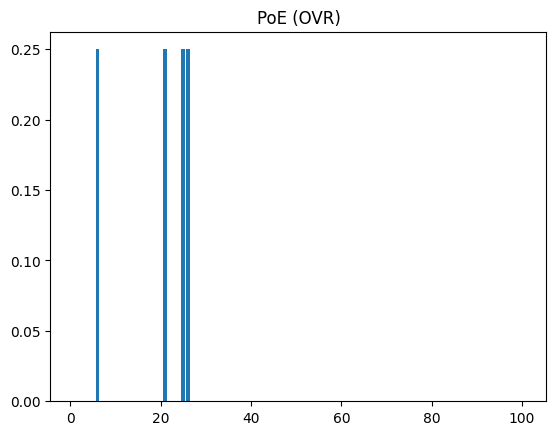

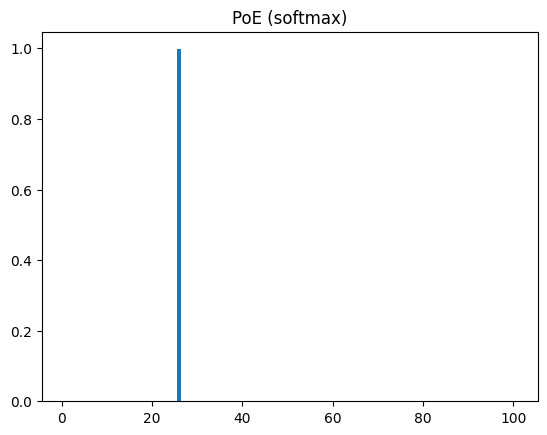

In [545]:
l, n = 6, 110

plt.bar(np.arange(1, 101, 1), probs_poe_ovr_break_ties[l, n, :].numpy())
plt.title('PoE (OVR, break-ties)')
plt.show()

plt.bar(np.arange(1, 101, 1), probs_poe_ovr[l, n, :].numpy())
plt.title('PoE (OVR)')
plt.show()

plt.bar(np.arange(1, 101, 1), probs_poe[l, n, :].numpy())
plt.title('PoE (softmax)')
plt.show()

## temperature scaling conundrum

In [546]:
toy_logits = torch.tensor([-0.1, 0., 0.1])
for T in [0.00001, 0.001, 0.1, 1., 10., 100., 1000.]:
    print(T, torch.round(torch.sigmoid(T * toy_logits) / torch.sigmoid(T * toy_logits).sum(), decimals=8))

1e-05 tensor([0.3333, 0.3333, 0.3333])
0.001 tensor([0.3333, 0.3333, 0.3334])
0.1 tensor([0.3317, 0.3333, 0.3350])
1.0 tensor([0.3167, 0.3333, 0.3500])
10.0 tensor([0.1793, 0.3333, 0.4874])
100.0 tensor([3.0270e-05, 3.3333e-01, 6.6664e-01])
1000.0 tensor([0.0000, 0.3333, 0.6667])


In [547]:
toy_logits_2 = torch.tensor([0.1, 0., -0.1])

In [548]:
toy_logits = torch.stack((torch.tensor([-0.1, -0.3, -0.1]), torch.tensor([-0.2, -0.05, -0.1])), dim=0)

In [549]:
torch.sigmoid(10 * toy_logits).prod(dim=0) / torch.sigmoid(10 * toy_logits).prod(dim=0).sum()

tensor([0.2621, 0.1464, 0.5914])

In [550]:
n = 100

T_a = 1
a = torch.sigmoid(T_a * logits[:3, 100, :]).prod(dim=0) / torch.sigmoid(T_a * logits[:3, n, :]).prod(dim=0).sum()

T_a_post_process = 0.5
a_post_process = scipy.special.softmax((T_a_post_process * logits[:3, n, :]).mean(dim=0))

In [551]:
a.argmax(), a.max(), a_post_process.argmax(), a_post_process.max()

(tensor(26), tensor(0.0447), 26, 0.90749425)

In [552]:
n = 15
T_b = 1.
b = scipy.special.softmax((T_b * logits[:3, n, :]).mean(dim=0))

In [553]:
b.max()

0.9999782

In [554]:
b.argmax()

43